In [1]:
# Import necessary libraries
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from tqdm.notebook import tqdm

# Set seed for reproducibility
pl.seed_everything(42)

Seed set to 42


42

In [2]:
from multissl.models import SegmentationModel
from multissl.plotting import visualize_batch, visualize_predictions
from multissl.data import SegmentationDataset

In [3]:
# Configuration
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "img_size": 224,
    "batch_size": 4,
    "num_workers": 0,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_512_r50_view4_v2/last.ckpt",  # Update with your checkpoint path
    "num_classes": 2,  # Update with your number of classes
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 400,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    
    # Misc
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs
    "class_names": ["Background","Vines"],  # Update with your class names
}

In [4]:
# Create train/val/test datasets
train_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "train_vary"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "train_vary"),
    img_size=CONFIG["img_size"]
)

val_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Train dataset size: 3
Validation dataset size: 97
Test dataset size valdoeiro: 157
Test dataset size qbaixo: 141


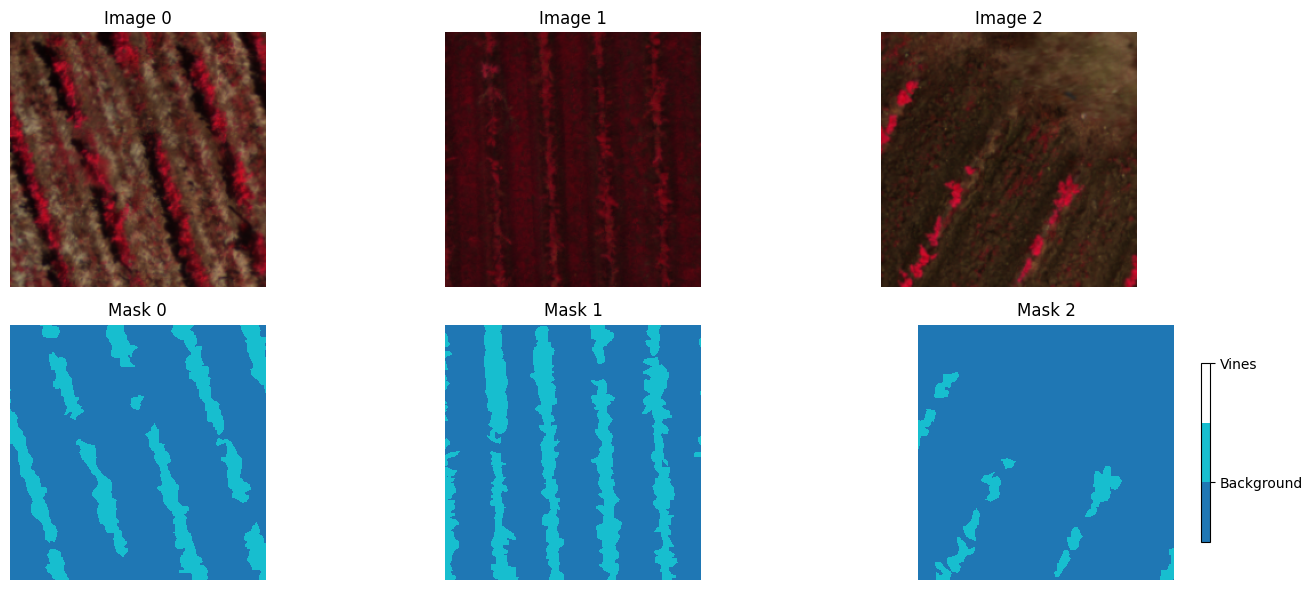

In [5]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch(
    batch, 
    num_samples=3, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [6]:
# For ResNet50 pretrained with FastSiam

model = SegmentationModel(
    backbone_type="resnet50",
    pretrained_path=CONFIG["pretrained_checkpoint"],
    in_channels=CONFIG["in_channels"],
    num_classes=CONFIG["num_classes"],
    lr = CONFIG["lr"],
    weight_decay = CONFIG["weight_decay"]
)


Detected feature dimensions: layer1=256, layer2=512, layer3=1024, layer4=2048


In [7]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="r50-all-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project="ViT-Segmentation", log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
    log_every_n_steps = 1,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
# Train the model
trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

wandb: Currently logged in as: jurriandoornbos (jurrain-phd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ feature_extractor │ ResNetExtractor  │ 23.5 M │ train │
│ 1 │ seg_head          │ SegmentationHead │  4.5 M │ train │
└───┴───────────────────┴──────────────────┴────────┴───────┘

Trainable params: 4.5 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 28.0 M                                                                                               
Total estimated model params size (MB): 112                                                                        
Modules in train mode: 178                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of 
training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=400` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
lr-AdamW,████▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▂███████████████████████████████
val_loss,█▇▇▆▆█▆▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,399
lr-AdamW,0.0
train_loss,0.11718
trainer/global_step,399
val_accuracy,0.84546


Detected feature dimensions: layer1=256, layer2=512, layer3=1024, layer4=2048


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.3785
Accuracy: 0.8472
Total F1 Score (micro-avg): 0.8472
Mean IoU: 0.6274

Per-class metrics:
Background:
  Precision: 0.8671
  Recall: 0.9345
  F1 Score: 0.8986
  IoU: 0.8167
Vines:
  Precision: 0.6697
  Recall: 0.5171
  F1 Score: 0.5770
  IoU: 0.4381

Confusion Matrix:
tensor([[3351049,  234058],
        [ 520099,  761866]], device='cuda:0')


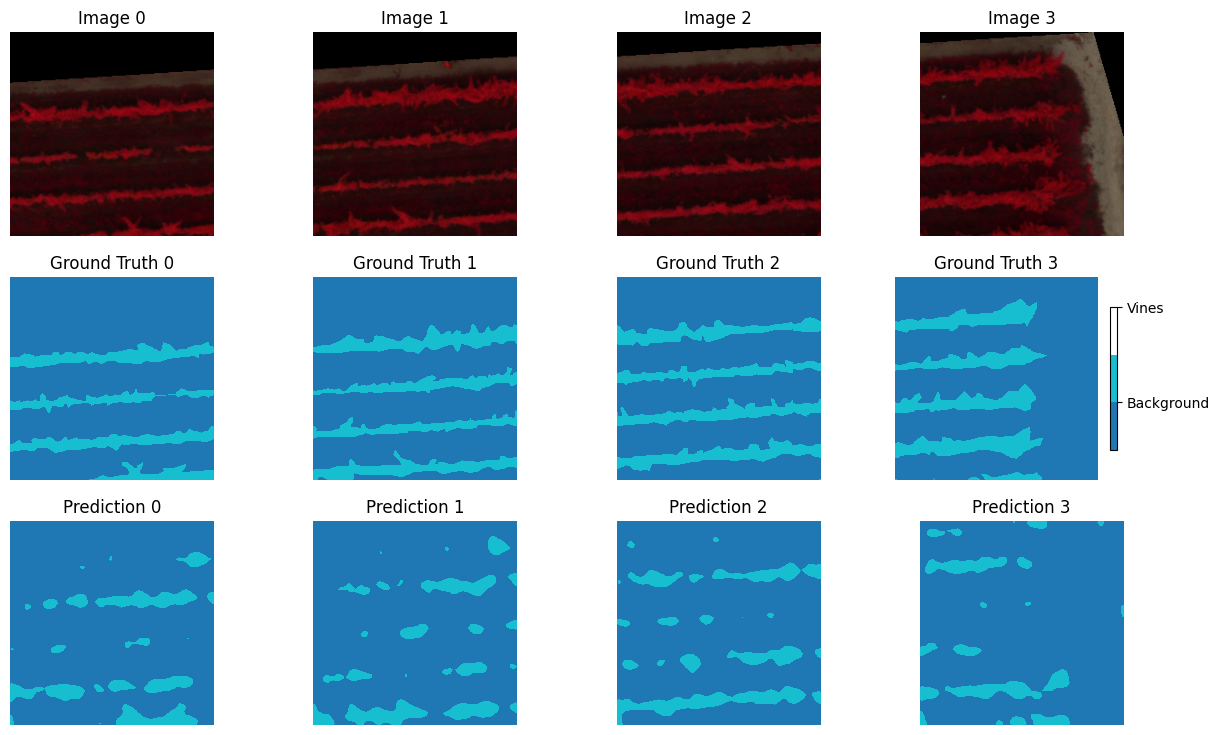

Loaded best model from C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints\r50-all-epoch=161-val_loss=0.3833.ckpt


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.1507
Accuracy: 0.9532
Total F1 Score (micro-avg): 0.9532
Mean IoU: 0.7629

Per-class metrics:
Background:
  Precision: 0.9828
  Recall: 0.9660
  F1 Score: 0.9743
  IoU: 0.9499
Vines:
  Precision: 0.6699
  Recall: 0.8116
  F1 Score: 0.7291
  IoU: 0.5758

Confusion Matrix:
tensor([[6991487,  247242],
        [ 124167,  514736]], device='cuda:0')


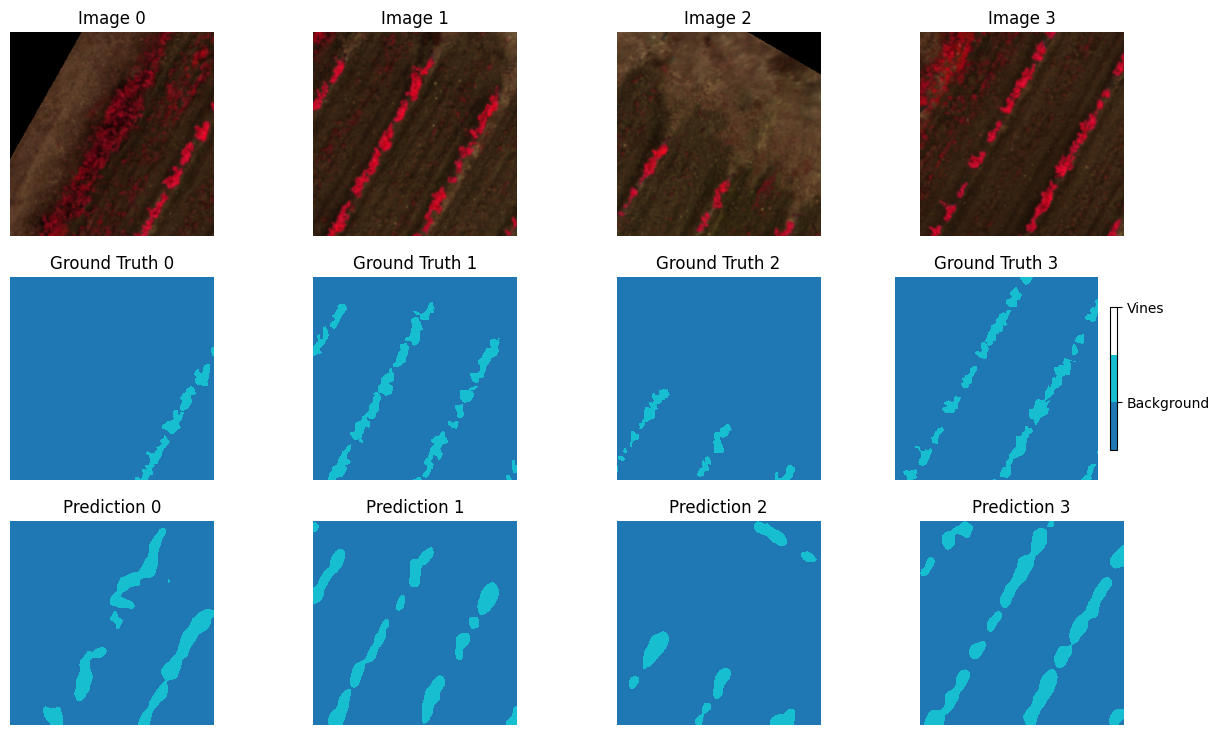

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.3690
Accuracy: 0.8690
Total F1 Score (micro-avg): 0.8690
Mean IoU: 0.6543

Per-class metrics:
Background:
  Precision: 0.8969
  Recall: 0.9470
  F1 Score: 0.9199
  IoU: 0.8526
Vines:
  Precision: 0.7267
  Recall: 0.5717
  F1 Score: 0.6194
  IoU: 0.4560

Confusion Matrix:
tensor([[5374031,  295548],
        [ 631971,  773266]], device='cuda:0')


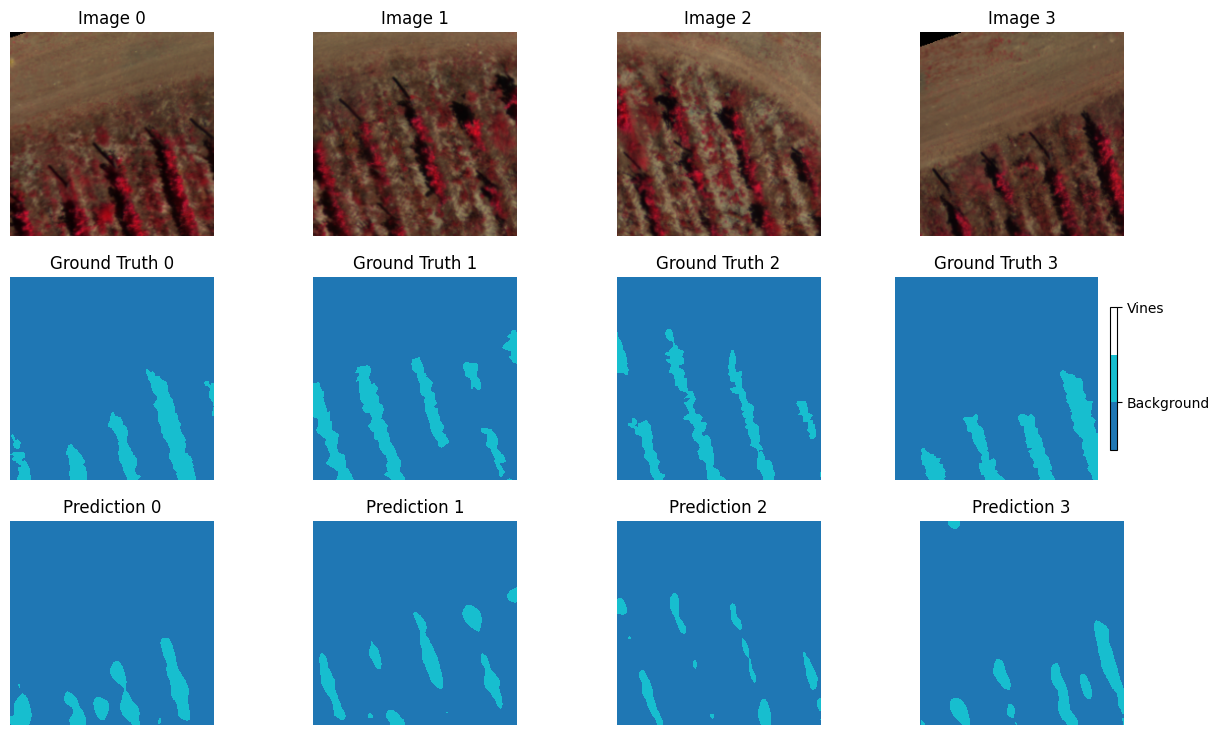

In [9]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.best_model_path
best_model = SegmentationModel.load_from_checkpoint(best_model_path)

best_model.eval()
uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

print(f"Loaded best model from {best_model_path}")
uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [73]:
# Save just the state dict for easier loading in production
model_state_dict_path = "segmentation_checkpoints/r50seg_all_best_state_dict.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")

Saved model state dict to segmentation_checkpoints/r50seg_all_best_state_dict.pth
